In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Dropout
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# load dataset
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Belajar Pengembangan Machine Learning/london_merged.csv')
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [5]:
# cek total dataset
df.shape

(17414, 10)

In [6]:
# cek apakah ada nilai yang hilang dari dataset
df.isnull().sum()

timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64

Text(0.5, 0, 'Timestamp')

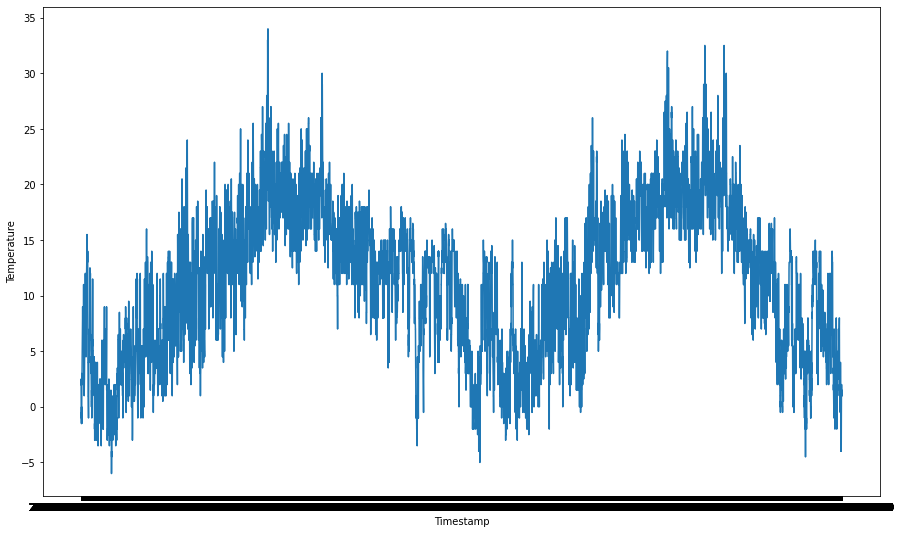

In [7]:
# buat plot
dates = df['timestamp'].values
temp = df['t2'].values

dates = np.array(dates)
temp = np.array(temp)

plt.figure(figsize=(15,9))
plt.plot(dates, temp)

plt.ylabel('Temperature')
plt.xlabel('Timestamp')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   timestamp     17414 non-null  object 
 1   cnt           17414 non-null  int64  
 2   t1            17414 non-null  float64
 3   t2            17414 non-null  float64
 4   hum           17414 non-null  float64
 5   wind_speed    17414 non-null  float64
 6   weather_code  17414 non-null  float64
 7   is_holiday    17414 non-null  float64
 8   is_weekend    17414 non-null  float64
 9   season        17414 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 1.3+ MB


In [9]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [10]:
# drop column yang tidak di butuhkan
df = df.drop(columns=['cnt','t1','hum', 'wind_speed', 'weather_code', 'is_holiday', 'is_weekend', 'season'])

In [11]:
# buat index
df.set_index('timestamp')

,t2
timestamp,
2015-01-04 00:00:00,2.0
2015-01-04 01:00:00,2.5
2015-01-04 02:00:00,2.5
2015-01-04 03:00:00,2.0
2015-01-04 04:00:00,0.0
...,...
2017-01-03 19:00:00,1.0
2017-01-03 20:00:00,1.0
2017-01-03 21:00:00,1.5


In [12]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(temp, dates, test_size = 0.2, random_state = 0 , shuffle=False)
print(len(x_train), len(x_test))

13931 3483


In [14]:
tf.keras.backend.set_floatx('float64')

train_set = windowed_dataset(x_train, window_size=64, batch_size=200, shuffle_buffer=1000)
validation_set = windowed_dataset(x_test, window_size=64, batch_size=200, shuffle_buffer=1000)

model = Sequential([
    Bidirectional(LSTM(60, return_sequences=True)),
    Bidirectional(LSTM(60)),
    Dense(30, activation="relu"),
    Dense(10, activation="relu"),
    Dense(1),
])

In [15]:
# buat fungsi callback
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae')<2.4 and logs.get('val_mae')<2.4):
      print("\nMAE < 10% skala data")
      self.model.stop_training = True
callbacks = myCallback()

In [16]:
# MAE < 10% skala data
Mae = (df['t2'].max() - df['t2'].min()) * 10/100

In [17]:
# buat optimizer
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-04, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set, epochs=100, validation_data = validation_set, callbacks=[callbacks])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/100
70/70 [==============================] - 91s 1s/step - loss: 10.6523 - mae: 11.1452 - val_loss: 10.7225 - val_mae: 11.2169
Epoch 2/100
70/70 [==============================] - 78s 1s/step - loss: 9.6944 - mae: 10.1863 - val_loss: 9.5188 - val_mae: 10.0111
Epoch 3/100
70/70 [==============================] - 78s 1s/step - loss: 8.0374 - mae: 8.5233 - val_loss: 7.1870 - val_mae: 7.6709
Epoch 4/100
70/70 [==============================] - 77s 1s/step - loss: 5.2635 - mae: 5.7454 - val_loss: 4.4179 - val_mae: 4.9057
Epoch 5/100
70/70 [==============================] - 77s 1s/step - loss: 3.4760 - mae: 3.9505 - val_loss: 3.4224 - val_mae: 3.8941
Epoch 6/100
70/70 [==============================] - 77s 1s/step - loss: 2.8784 - mae: 3.3458 - val_loss: 2.9215 - val_mae: 3.3916
Epoch 7/100
70/70 [==============================] - 78s 1s/step - loss: 2.2786 - mae: 2.7359 - val_loss: 2.4131 - val_mae: 2.8765
Epoch 8/100
70/70 [==============================] - 77s 1s/step - loss: 2.01

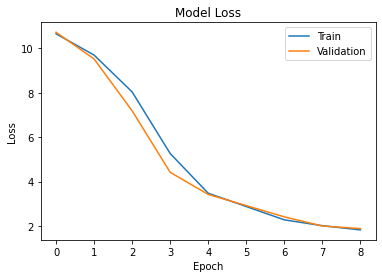

In [18]:
# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

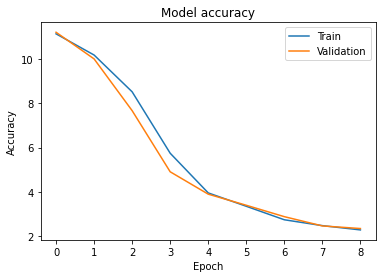

In [19]:
# plot accuracy
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()